In [3]:
import polars as pl


In [4]:
data_en = pl.read_csv("./df_en.csv")

In [5]:
data_en.columns

['filename',
 'company_name',
 'year',
 'Name',
 'Year',
 'file',
 'Organization_type',
 'Size',
 'Sector',
 'Sec_SASB',
 'Country',
 'Region',
 'OECD',
 'english_non_english',
 'file_full_name',
 'file_empty',
 'Group',
 'text',
 'text_clean',
 'clean_len']

In [6]:
print("Individual english reports")
len(data_en) 

Individual english reports


1653

## How do we want to design our sample? 

to decide, we need to look at how balanced our data is. Are any companies overrepresented with several reports within one year and one sector-group? 

are the sector groups balanced in representation over the years (/ or time periods?)

In [7]:
# How frequently do individual companies appear in our current sample of only english reports? 

company_counts = (
    data_en
    .group_by("company_name")
    .len()
    .sort("len", descending=True)
)

company_counts

company_name,len
str,u32
"""TERUMO""",9
"""InfosysLimited""",8
"""JtektCorporation""",7
"""IinoLines""",7
"""Iwatani""",7
…,…
"""HAESL(HongKongAeroEnginesServi…",1
"""TernaGroup""",1
"""NEIInvestments""",1


In [8]:

company_counts.select(
    [
        pl.col("len").min().alias("min"),
        pl.col("len").max().alias("max"),
        pl.col("len").mean().alias("mean"),
        pl.col("len").median().alias("median"),
    ]
)

min,max,mean,median
u32,u32,f64,f64
1,9,1.590953,1.0


are there cases with multiple reports per company-year-sector-group?

In [14]:
companies_year_sector = data_en.group_by(["company_name","year","Group"]).len().sort("len", descending=True)

# this is good, it means that no company is represented with more than 1 report in a year within one sector group.
# this also means we can use this df_en as a balanced sample to observe topic changes over time periods per sector-group,
# if we choose to go with sector-group as our unit of analysis.

In [ ]:
for l in companies_year_sector["len"]: 
    if l > 1:
        print("has more than one report per year per sector")
    


Some companies are represented in the dataset with up to 9 reports, while many others appear with only 1 published report. <br>
But no company is represented with more than 1 report in a year within one sector group. <br>
So for a sample where the unit of comparison are topics at the level of sector-groups across years, this makes for a reasonable choice, because the reports from companies with more reports than others are distributed in a balanced manner across the different sector groups and years. 

In [ ]:
# checking how many reports the sample contains for each sector group 
sector_counts = (
    data_en
    .group_by("Group")
    .len()
    .sort("len", descending=True)
)

sector_counts

Group,len
str,u32
"""Industrial""",479
"""Other""",434
"""Financial""",394
"""Consumer""",346


our sector groups are roughly balanced in the numbers of english language reports 

Reports per sector x year with english language sample:

In [ ]:
sector_year = (
    data_en
    .group_by(["Group", "year"])
    .len()
    .sort(["Group", "year"])
)

sector_year

Group,year,len
str,i64,u32
"""Consumer""",2002,1
"""Consumer""",2004,1
"""Consumer""",2005,2
"""Consumer""",2006,4
"""Consumer""",2007,11
…,…,…
"""Other""",2014,65
"""Other""",2015,63
"""Other""",2016,99


Visualizing how the number of english language reports in our dataset is balanced across the sector-groups over time: 
> this is how we make sure that when measuring and comparing topics across sector-groups over time we don't end up with effects in our data occuring due to a very uneven distribution in the number of reports across sector-groups. 

> we can see that the lines are somewhat close to each other

In [ ]:
sector_pd = sector_year.to_pandas()

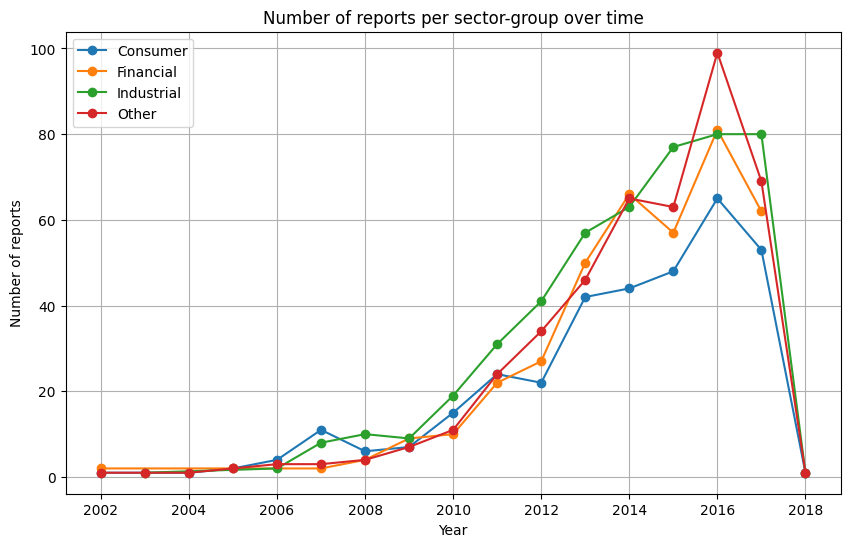

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for g, df in sector_pd.groupby("Group"):
    plt.plot(df["year"], df["len"], marker="o", label=g)

plt.xlabel("Year")
plt.ylabel("Number of reports")
plt.title("Number of reports per sector-group over time")
plt.legend()
plt.grid(True)
plt.show()